In [158]:

# NLP Project    
import pandas as pd
import os
from pathlib import Path
import spacy
import nltk
from nltk.corpus import wordnet
import random
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('wordnet')
nltk.download('omw-1.4')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [159]:
def spacy_pos_to_wordnet_pos(spacy_pos):
    if spacy_pos.startswith('N'):
        return wordnet.NOUN
    elif spacy_pos.startswith('V'):
        return wordnet.VERB
    elif spacy_pos.startswith('J'):
        return wordnet.ADJ
    elif spacy_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default fallback


In [160]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)      # Remove the original word to avoid replacement with itself
    return list(synonyms)

In [161]:
def augment_text_with_synonyms(tokens, pos_tags, synonym_probability=0.2):
    augmented_tokens = []
    
    for token, pos_tag in zip(tokens, pos_tags):
        if random.random() < synonym_probability:
            if pos_tag in ['n', 'v', 'a']:   #nouns adjectives and verbs 
                synonyms = get_synonyms(token)
                if synonyms:
                    new_word = random.choice(synonyms)
                    augmented_tokens.append(new_word)
                    continue  
        augmented_tokens.append(token)         # Add the original word if no augmentation is done
    
    return augmented_tokens

In [162]:
def apply_augmentation_to_dataset(word_tokens, pos_tags, texts, labels, sentence_tokens, synonym_probability=0.2):
    all_word_tokens = word_tokens.copy()
    all_texts = texts.copy()  # Original text is preserved
    all_labels = labels.copy()
    all_sentence_tokens = sentence_tokens.copy()
    all_pos_tags = pos_tags.copy()

    for tokens, pos, label, sentence, text in zip(word_tokens, pos_tags, labels, sentence_tokens, texts):
        augmented_tokens = augment_text_with_synonyms(tokens, pos, synonym_probability)

        all_word_tokens.append(augmented_tokens)
        all_texts.append(text)  # Keep the original text
        all_labels.append(label)
        all_pos_tags.append(pos)
        all_sentence_tokens.append(sentence)  # Sentence tokens are not augmented

    return all_word_tokens, all_pos_tags, all_texts, all_labels, all_sentence_tokens





In [163]:
def apply_lemmatization(tokens):
    return [token.lemma_ for token in nlp(' '.join(tokens)) if not token.is_punct and not token.is_space]


In [164]:
def apply_stemming(text):
    
    words = text.split()
    return ' '.join([PorterStemmer().stem(word) for word in words])


In [ ]:

def visualize_heatmap(tfidf_matrix, vectorizer, num_docs=10, num_features=20):
    subset = tfidf_matrix[:num_docs, :num_features].toarray()
    plt.figure(figsize=(12, 6))
    sns.heatmap(subset, annot=True, cmap="YlGnBu", xticklabels=vectorizer.get_feature_names_out()[:num_features])
    plt.title(f"TF-IDF Heatmap (Top {num_features} Features, First {num_docs} Documents)")
    plt.xlabel("Words")
    plt.ylabel("Documents")
    plt.tight_layout()    plt.show()

In [ ]:
def create_sentiment_dataset():
    texts = []
    labels = []
    word_tokens = []
    sentence_tokens = []
    pos_tags = []
    
    base_path = Path('review_polarity/txt_sentoken')
    pos_path = base_path / 'pos'
    neg_path = base_path / 'neg'
    
    if pos_path.exists():
        for file in pos_path.glob('*.txt'):
            with open(file, 'r', encoding='utf-8') as f:
                text = f.read()
                texts.append(text)

                doc = nlp(text)
                sentence_tokens.append([sent.text.strip() for sent in doc.sents])
                tokens = [token for token in doc if not token.is_punct and not token.is_stop and not token.is_space]
                word_tokens.append([token.text.lower() for token in tokens])  
                pos_tags.append([spacy_pos_to_wordnet_pos(token.tag_) for token in tokens])
                    


                labels.append(1)

    
    if neg_path.exists():
        for file in neg_path.glob('*.txt'):
            with open(file, 'r', encoding='utf-8') as f:
                text = f.read()
                texts.append(text)

                doc = nlp(text)
                sentence_tokens.append([sent.text.strip() for sent in doc.sents])
                tokens = [token for token in doc if not token.is_punct and not token.is_stop and not token.is_space]
                word_tokens.append([token.text.lower() for token in tokens])  
                pos_tags.append([spacy_pos_to_wordnet_pos(token.tag_) for token in tokens])

                labels.append(0)
                
    lemmatized_tokens = [apply_lemmatization(t) for t in word_tokens]
    print("Sample lemmatized tokens:")
    for i in range(3):
        print(lemmatized_tokens[i][:20])

    word_tokens, pos_tags, texts, labels, sentence_tokens = apply_augmentation_to_dataset(lemmatized_tokens, pos_tags, texts, labels, sentence_tokens)
    
    joined_texts = [' '.join(tokens) for tokens in word_tokens]
    print("Sample joined tokens:")
    for i in range(3):
        print(joined_texts[i][:20])
        
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(joined_texts)

    print("\nTF-IDF Feature Names:")
    print(vectorizer.get_feature_names_out())
    print("\nTF-IDF Matrix:")
    print(tfidf_matrix.toarray())
    visualize_heatmap(tfidf_matrix , vectorizer)
    df = pd.DataFrame({
        'text': texts,
        'word_tokens': word_tokens,
        'sentence_tokens': sentence_tokens,
        'label': labels,
        'pos_tags': pos_tags
    })
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(df)
    return df




Sample lemmatized tokens:
['film', 'adapt', 'comic', 'book', 'plenty', 'success', 'superhero', 'batman', 'superman', 'spawn', 'gear', 'kid', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'comic', 'book', 'like']
['movie', 'come', 'suspect', 'studio', 'indication', 'stinker', 'everybody', 'surprise', 'studio', 'film', 'critical', 'darling', 'mtv', 'film', 'election', 'high', 'school', 'comedy', 'star', 'matthew']
['get', 'mail', 'work', 'alot', 'well', 'deserve', 'order', 'film', 'success', 'cast', 'extremely', 'popular', 'attractive', 'star', 'share', 'screen', 'hour', 'collect', 'profit', 'real']
Sample joined tokens:
film adapt comic boo
movie come suspect s
get mail work alot w

TF-IDF Feature Names:
['00' '000' '0009f' ... 'zwigoff' 'zycie' 'zzzzzzz']

TF-IDF Matrix:
[[0.06536551 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.      

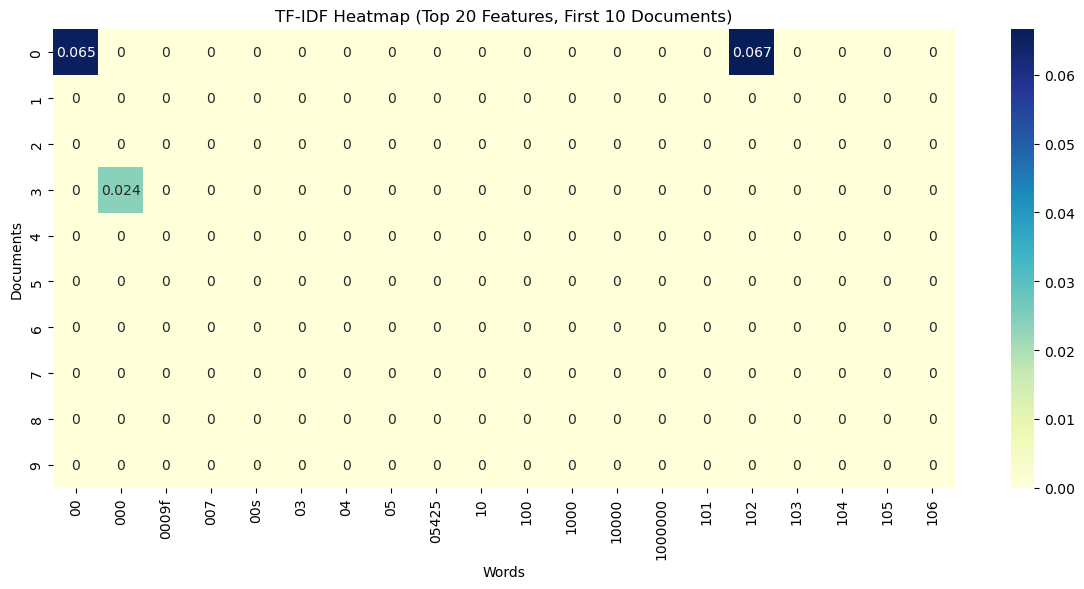

                                                   text  \
0     harmless , silly and fun comedy about dim-witt...   
1     at one point in this movie there is a staging ...   
2     sick : the life and death of bob flanagan , su...   
3     everybody in this film's thinking of alicia . ...   
4     lisa cholodenko's " high art , " is an intelli...   
...                                                 ...   
3995  i never understood what the clich ? " hell on ...   
3996  in this re-make of the 1954 japanese monster f...   
3997  the verdict : spine-chilling drama from horror...   
3998  midway through " anaconda " , documentary film...   
3999  starship troopers is a bad movie . \ni mean , ...   

                                            word_tokens  \
0     [harmless, silly, fun, comedy, dim, witted, wr...   
1     [point, movie, staging, opera, go, completely,...   
2     [sick, life, death, bob, flanagan, supermasoch...   
3     [everybody, picture, cogitate, alicia, documen...

In [167]:

if __name__ == "__main__":
    # Create the dataset
    df = create_sentiment_dataset()
    
    # Display first few rows and basic information
    # print("\nFirst few rows of the dataset:")
    # df.head()

    print("\nDataset shape:", df.shape)
    print("\nLabel distribution:")
    print(df['label'].value_counts())
    # print(df.head(20))
    # Print the first 20 rows of the dataframe
    # Print tokens from the first 20 rows
    print("Tokens in the first 20 rows:")
    print(df['word_tokens'].head(20))
    
    # Print tokens from rows with index 2000 to 2020
    # print("\nTokens from index 2000 to 2020:")
    # print(df['word_tokens'].iloc[2000:2021])


    # # # Display tokenization examples
    # print("\nExample of word tokenization for first review:")
    # print("Number of words:", len(df['word_tokens'][0]))
    # print("First 20 words:", df['word_tokens'][0][:20])
    
    # print("\nExample of sentence tokenization for first review:")
    # print("Number of sentences:", len(df['sentence_tokens'][0]))
    # print("First 2 sentences:", df['sentence_tokens'][0][:2])  

    # print("\nExample of POS tags for first review:")
    # print("POS tags:", df['pos_tags'][0][:20])  # Display first 20 POS tags